## Are university towns housing prices less affected by recession?

In this data analysis project, we will formulate a hypothesis around this question, gather and process required data and finally test our hypothesis.

### Strategy

We will use 3 datasources for this project. 
1. We will use GDP data from Bureau of Economic Analysis, US Department of Commerce, the GDP over time of the United States in current dollars (using the chained value in 2009 dollars), in quarterly intervals, in the file gdplev.xls. We will use this data to determine recession periods. For this project, we will only look at GDP data from the first quarter of 2000 onward.

2. We will use housing price data from the Zillow research data site. There is housing data for the United States. In particular the datafile for all homes at a city level, 'City_Zhvi_AllHomes.csv', has median home sale prices at a fine grained level.

3. We will use a list of university towns collected from Wikipedia to divide the housing price data in two sets as university towns and non-university towns. We have this data in the 'university_towns.txt' file.

So, we will use the above mentioned data sources and manipulate and transform them to test our hypothesis.

### Hypothesis
#### University towns have their mean housing prices less affected by recessions.

### Required Definitions
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.


In [9]:
### Import necessary libraries

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [11]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Remove newline character '\n'. '''
    ut_list = []
    
    with open('university_towns.txt') as f:
        for line in f:
            if 'edit' in line:
                current_city = line.split('[')[0].strip()
            else:
                ut_list.append((current_city, line.split('(')[0].strip()))
                
    ut_df = pd.DataFrame.from_records(ut_list)
    ut_df.columns = ['State', 'RegionName']
    return ut_df

In [12]:
ut_df = get_list_of_university_towns()
ut_df.head()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo


In [13]:
def get_gdp_df():
    '''this function reads the gdp data and returns a dataframe with only the required columns'''
    gdplev = pd.ExcelFile('gdplev.xls')
    gdplev = gdplev.parse("Sheet1", skiprows=219)
    gdplev = gdplev[['1999q4', 9926.1]]
    gdplev.columns = ['quarter','gdp']
    return gdplev

Let's look at the gdp data visually first.

In [14]:
gdp = get_gdp_df()

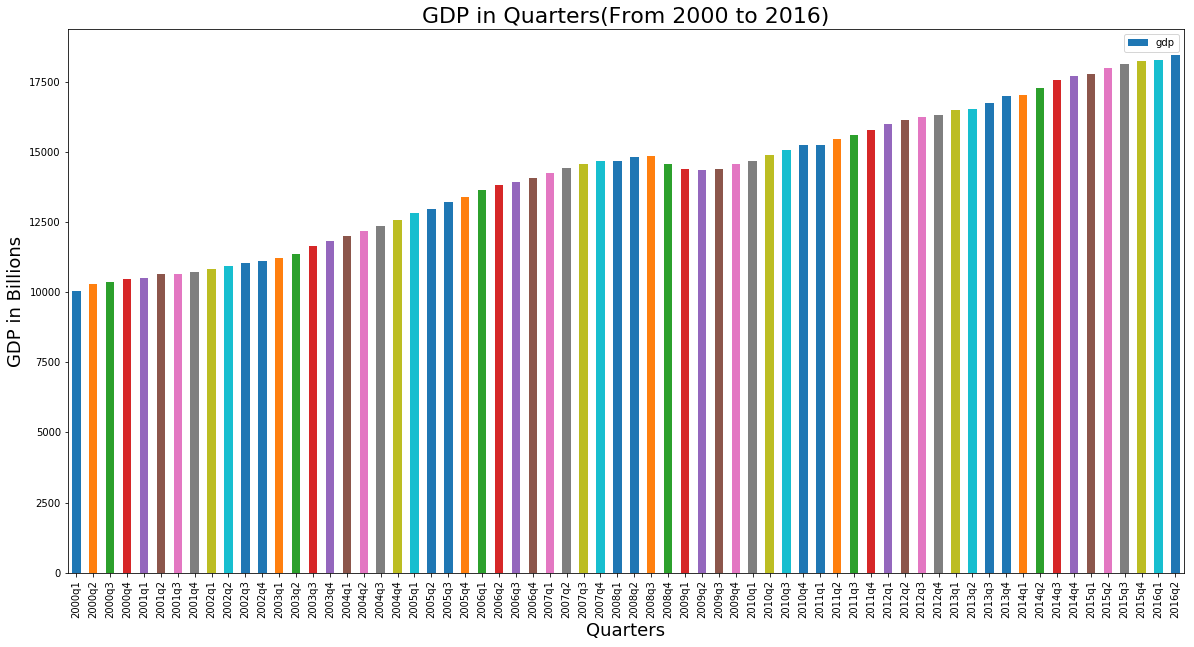

In [29]:
ax = gdp.plot.bar(figsize=(20, 10),  legend=True, x='quarter', y='gdp')
plt.title('GDP in Quarters(From 2000 to 2016)', fontsize='22')
plt.ylabel('GDP in Billions', fontsize='18')
plt.xlabel('Quarters', fontsize='18')
plt.show()

 We can see there's small dip in the middle. Let's find out the recession period and look at it more closely.

In [16]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    gdplev = get_gdp_df()
    for i in range(2, len(gdplev)):
        if (gdplev.iloc[i-2][1] > gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] > gdplev.iloc[i][1]):
            return gdplev.iloc[i-2][0]


The above function finds the start of a recession based on the definition above. Let's run this and find the starting point for recession.

In [17]:
get_recession_start()

'2008q3'

So, within our window of analysis, a recession had started in the 3rd quarter of 2008 as is well known

This function finds the end of a recession according to the definition.

In [18]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''

    gdplev = get_gdp_df()
    start = get_recession_start()
    start_index = gdplev[gdplev['quarter'] == start].index.tolist()[0]
    gdplev=gdplev.iloc[start_index:]
    for i in range(2, len(gdplev)):
        if (gdplev.iloc[i-2][1] < gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] < gdplev.iloc[i][1]):
            return gdplev.iloc[i][0]

Let's run this and find out the end of the recession period

In [19]:
get_recession_end()

'2009q4'

So, the recession ended in the last quarter of 2009. It lasted over a year!

Now let's figure out the bottom of the recession

In [20]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    gdp = get_gdp_df()
    a = gdp.index[gdp['quarter'] == get_recession_start()][0]
    b = gdp.index[gdp['quarter'] == get_recession_end()][0]
    
    
    return gdp.iloc[gdp.iloc[a:b+1, 1 ].idxmin(), 0]

In [21]:
get_recession_bottom()

'2009q2'

Now, that we have figured out the recession period, let's visualize the period.

In [22]:
recession_start_index = gdp.loc[gdp.quarter == get_recession_start(), :].index[0]
recession_end_index = gdp.loc[gdp.quarter == get_recession_end(), :].index[0]

In [23]:
# we take two previous quarters before recession into account to capture the start of recession in the graph
recession = gdp.iloc[recession_start_index-2: recession_end_index+1, :] 

([<matplotlib.axis.XTick at 0x2272feb0588>,
 <a list of 8 Text xticklabel objects>)

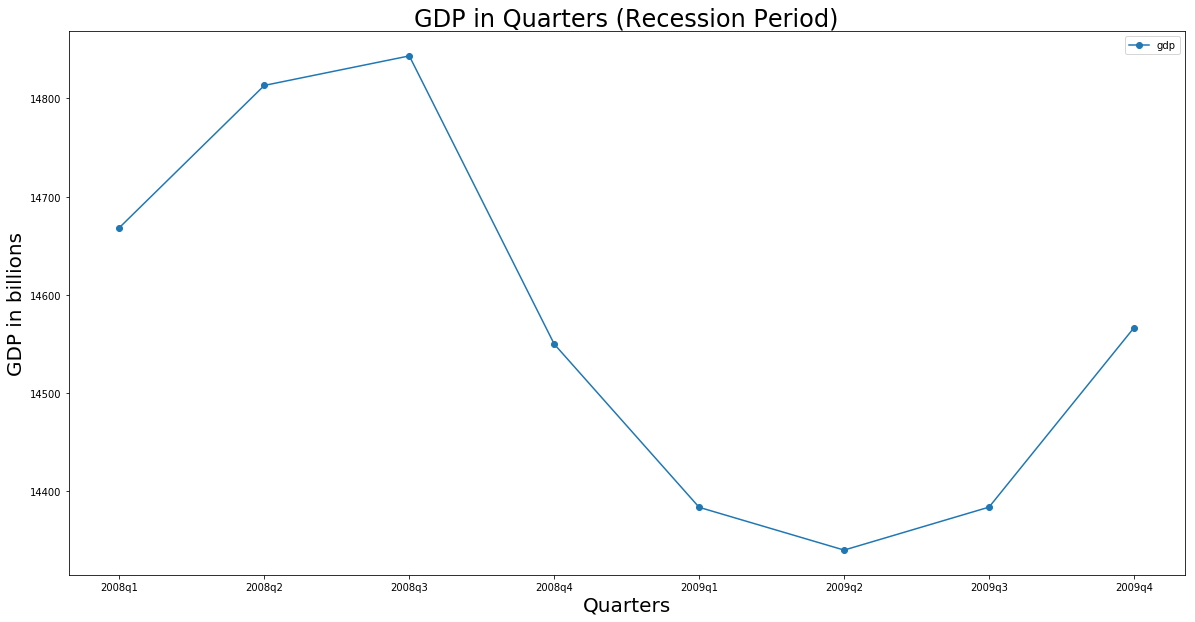

In [30]:
recession.set_index('quarter').plot.line(figsize=(20, 10), style='-', marker='o')
plt.title('GDP in Quarters (Recession Period)', fontsize='24')
plt.xlabel('Quarters', fontsize="20")
plt.ylabel('GDP in billions', fontsize='20')
plt.xticks([x for x in range(len(recession.index))], recession.quarter)

So, the 2nd quarter of 2009 had the lowest GDP. We can see two consecutive decrease starting from 2008q3 and two consecutive growth starting from 2009q3. So, 2009q4 marks the end of this recession period.

So, we have determined the important data points related to recession. Let's look into the housing price data now.

In [12]:
zillow = pd.read_csv('City_Zhvi_AllHomes.csv')
zillow.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
0,6181,New York,NY,New York,Queens,1,NaN,NaN,NaN,NaN,...,573600,576200,578400,582200,588000,592200,592500,590200,588000,586400
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2,155000.0,154600.0,154400.0,154200.0,...,558200,560800,562800,565600,569700,574000,577800,580600,583000,585100
2,17426,Chicago,IL,Chicago,Cook,3,109700.0,109400.0,109300.0,109300.0,...,207800,206900,206200,205800,206200,207300,208200,209100,211000,213000
3,13271,Philadelphia,PA,Philadelphia,Philadelphia,4,50000.0,49900.0,49600.0,49400.0,...,122300,121600,121800,123300,125200,126400,127000,127400,128300,129100
4,40326,Phoenix,AZ,Phoenix,Maricopa,5,87200.0,87700.0,88200.0,88400.0,...,183800,185300,186600,188000,189100,190200,191300,192800,194500,195900


In [13]:
zillow.shape

(10730, 251)

So, after the first look at the data it seems we need the following cleaning:
* The states are in short names, so we need to transform this.
* It contains month by month prices from 1996, we only need data from 2001 so drop the unnecessary columns.
* Use the state and region name for indexing.
* Finally, convert month by month data to quarterly data.

So, let's get to work!

In [14]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean housing price    
    values in a dataframe. This  is a dataframe with
    columns for 2000q1 through 2016q3, and have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the definition, they are
    not arbitrary three month periods.
        
    '''
    zillow = pd.read_csv('City_Zhvi_AllHomes.csv')
    zillow['State'] = zillow['State'].map(states)
    zillow.set_index(['State', 'RegionName'], inplace=True)
    zillow = zillow.loc[:, '2000-01': ]
    
    new_columns = [str(x)+y for x in range(2000, 2017) for y in ['q1', 'q2', 'q3', 'q4']]
    new_columns = new_columns[:-1] # drop the last quarter of 2016
    
    x = 0

    for c in new_columns:
        zillow[c] = zillow.iloc[:, x:x+3].mean(axis=1)
        x = x+3
    
    zillow = zillow.loc[:, '2000q1':]
    
    
    return zillow



Let's take a look at the shape of the transformed zillow data. It should have the same number of rows as the original file that is 10730 and the number of columns should be 67 (4 quarters in 17 years minus the last  quarter in 2016)

In [15]:
convert_housing_data_to_quarters().shape

(10730, 67)

Let's have a peek at the data.

In [16]:
convert_housing_data_to_quarters().head()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,515466.666667,522800.000000,528066.666667,532266.666667,540800.000000,557200.000000,572833.333333,582866.666667,591633.333333,587200.000000
California,Los Angeles,207066.666667,214466.666667,220966.666667,226166.666667,233000.000000,239100.000000,245066.666667,253033.333333,261966.666667,272700.000000,...,498033.333333,509066.666667,518866.666667,528800.000000,538166.666667,547266.666667,557733.333333,566033.333333,577466.666667,458388.888889
Illinois,Chicago,138400.000000,143633.333333,147866.666667,152133.333333,156933.333333,161800.000000,166400.000000,170433.333333,175500.000000,177566.666667,...,192633.333333,195766.666667,201266.666667,201066.666667,206033.333333,208300.000000,207900.000000,206066.666667,208200.000000,187466.666667
Pennsylvania,Philadelphia,53000.000000,53633.333333,54133.333333,54700.000000,55333.333333,55533.333333,56266.666667,57533.333333,59133.333333,60733.333333,...,113733.333333,115300.000000,115666.666667,116200.000000,117966.666667,121233.333333,122200.000000,123433.333333,126933.333333,103466.666667
Arizona,Phoenix,111833.333333,114366.666667,116000.000000,117400.000000,119600.000000,121566.666667,122700.000000,124300.000000,126533.333333,128366.666667,...,164266.666667,165366.666667,168500.000000,171533.333333,174166.666667,179066.666667,183833.333333,187900.000000,191433.333333,167411.111111


So, the data is prepared as desired. Now, we will move into the final phase of the analysis.
* We only need to look at the recession period, so we will narrow the columns to recession period.
* We need a price ratio column to compare the prices between the start and bottom of the recession.
* We need to split the data into university towns and non-university towns to run t-test on our hypothesis.

In [17]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Returns the tuple (different, p, lower) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The
    value for lower should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''

    # get the start of recession
    start = get_recession_start()
    #get the bottom of the recession
    bottom = get_recession_bottom()
    # get the zillow housing data in desired format
    housing_data = convert_housing_data_to_quarters()
    # keep only the columns from recession starting point and bottom.
    housing_data = housing_data.loc[:, start: bottom]
    # compute price ratio between the recession points and add it as a column.
    housing_data.reset_index(inplace=True)
    housing_data['price_ratio'] = (housing_data[start] - housing_data[bottom]) / housing_data[start]
    # get the university town list to split the data.
    uni_towns = get_list_of_university_towns()  
    uni_town_list = uni_towns['RegionName'].tolist()
    # add a column to use as splitting condition
    housing_data['isUniTown'] = housing_data.RegionName.apply(lambda x: x in uni_town_list)
    #split the data into two separate dataframes and drop rows with missing values. The dropping step is needed to 
    #perform the t-test
    uni_data = housing_data[housing_data.isUniTown].copy().dropna()
    not_uni_data = housing_data[~housing_data.isUniTown].copy().dropna()
    # get the p-value by applying t-test on these two dataframe columns.
    p = ttest_ind(uni_data['price_ratio'], not_uni_data['price_ratio'])[1]
    # this boolean value will tell us whether we can reject the null hyopthesis or not.
    different = p < 0.01   
    # this metric will tell us which type of town has the lower housing price ratio (mean) during the recession
    lower = 'university town' if uni_data['price_ratio'].mean() < not_uni_data['price_ratio'].mean() else 'non-university town'
    
    return (different, p, lower)


Now, let's run the ttest to validate our hypothesis!

In [18]:
run_ttest()

(True, 0.00036641601595526971, 'university town')

**The p-value is well below the 0.05 threshold and so we can reject the null hypothesis and claim that housing prices in university towns are less affected by recession.**